### 1. Import libraries and get data

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
# Load the dataset
df = pd.read_csv("./BTC.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df

,Price
Date,
2017-12-01,10861.5
2017-12-02,10912.7
2017-12-03,11246.2
2017-12-04,11623.9
2017-12-05,11667.1
...,...
2023-03-28,27262.2
2023-03-29,28350.4
2023-03-30,28029.5


### 2. Split the data into training, test and validate sets

In [17]:
train_size = int(0.7 * len(df))
test_size = int(0.15 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1363, 1)
Test shape: (292, 1)
Validate shape: (293, 1)


In [18]:
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1168, 1)
Test shape: (389, 1)
Validate shape: (391, 1)


In [19]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1363, 1)
Test shape: (389, 1)
Validate shape: (196, 1)


## 3. Perform GBT Model

### 3.1 Build and fit GBT Model with train data

In [20]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
gbt_model = GradientBoostingRegressor(learning_rate=0.01, random_state=42)
gbt_model.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, random_state=42)

### 3.2 Evaluate on Validate data

In [21]:
def evaludate_gbt_model(x_data, y_data):
    predictions = gbt_model.predict(x_data)
    mse = mean_squared_error(y_data, predictions)
    mae = mean_absolute_error(y_data, predictions)
    mape = mean_absolute_percentage_error(y_data, predictions)
    rmse = mean_squared_error(y_data, predictions, squared=False)
    return predictions, mse, mae, mape, rmse

In [22]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val, val_mse, val_mae, val_mape, val_rmse = evaludate_gbt_model(x_val, y_val)

print("Price predict on validate data:", y_pred_val)

Price predict on validate data: [33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.28179872
 33763.28179872 33763.28179872 33763.28179872 33763.2

In [23]:
print("Validation MSE: ", val_mse)
print("Validation MAPE: ", val_mape)
print("Validation MAE: ", val_mae)
print('Validation RMSE:', val_rmse)

Validation MSE:  190018436.13791826
Validation MAPE:  0.6981716712677893
Validation MAE:  13369.73945177826
Validation RMSE: 13784.717484878616


### 3.3 Evaluate on Test data

In [24]:
x_test= np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred_test, test_mse, test_mae, test_mape, test_rmse = evaludate_gbt_model(x_test, y_test)

print(y_test)
print("Price predict on test data:", y_pred_test)

[[48994.5]
 [46831.6]
 [49064.3]
 [48897.1]
 [48777.4]
 [46992.7]
 [47130.4]
 [48819.4]
 [49274.3]
 [49999. ]
 [49918.4]
 [51768.6]
 [52672.1]
 [46779.6]
 [46061.4]
 [46385.6]
 [44842.8]
 [45161.9]
 [46062.3]
 [44949.5]
 [47077.5]
 [48130.6]
 [47748. ]
 [47282.8]
 [48306.7]
 [47238.7]
 [42870.6]
 [40651.3]
 [43551.6]
 [44869.2]
 [42819.9]
 [42686.8]
 [43203.4]
 [42172.6]
 [41022.3]
 [41536.8]
 [43823.3]
 [48146. ]
 [47666.9]
 [48200.1]
 [49227.3]
 [51469.3]
 [55323.2]
 [53783.9]
 [53914.7]
 [54942.5]
 [54687.7]
 [57477.3]
 [56015.9]
 [57380.1]
 [57345.8]
 [61672.5]
 [60861.1]
 [61527.5]
 [62056.3]
 [64278.5]
 [65979.1]
 [62210.2]
 [60690.3]
 [61312.5]
 [60866.5]
 [63067. ]
 [60310.8]
 [58438.1]
 [60582.5]
 [62242.8]
 [61840.1]
 [61309.6]
 [60915.3]
 [63221.7]
 [62918.5]
 [61412.6]
 [60974.3]
 [61483.9]
 [63273.2]
 [67527.9]
 [66904.4]
 [64932.6]
 [64806.7]
 [64134.5]
 [64398.6]
 [65508.2]
 [63597.9]
 [60089.1]
 [60367.8]
 [56955.3]
 [58083.4]
 [59717.6]
 [58714.3]
 [56308.8]
 [57573.2]

### 3.4 Predict price for the next 30 days

In [25]:
last_index = len(df)
date_range = pd.date_range(start=df.index[-1], periods=30, freq='D')

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = gbt_model.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[13745.42537687 13745.42537687 13745.42537687 13745.42537687
 13745.42537687 13745.42537687 13745.42537687 13745.42537687
 13745.42537687 13745.42537687 13745.42537687 13745.42537687
 13745.42537687 13745.42537687 13745.42537687 13745.42537687
 13745.42537687 13745.42537687 13745.42537687 13745.42537687
 13745.42537687 13745.42537687 13745.42537687 13745.42537687
 13745.42537687 13745.42537687 13745.42537687 13745.42537687
 13745.42537687 13745.42537687]


In [26]:
metrics = {
    'MSE': [val_mse, test_mse],
    'MAE': [val_mae, test_mae],
    'MAPE': [val_mape, test_mape],
    'RMSE': [val_rmse, test_rmse],
}

df = pd.DataFrame(metrics, index=['Validate', 'Test'])

print(df)

                   MSE           MAE      MAPE          RMSE
Validate  1.900184e+08  13369.739452  0.698172  13784.717485
Test      2.013254e+08  12259.901479  0.331723  14188.917983


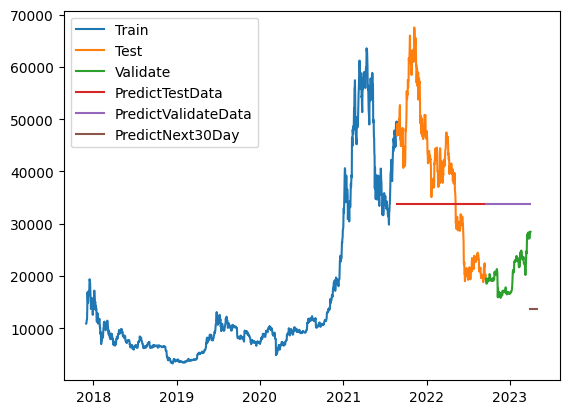

In [27]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])

plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(date_range, y_next_30_days)

plt.legend(['Train', 'Test', 'Validate','PredictTestData', 'PredictValidateData','PredictNext30Day'])
plt.show()